# Fair Robust Learning (FRL)-- Reweight Approach

The FRL algorithm the authors describe draws on the observation that "robust error" can be separated into "natural error" (i.e. the probability that the model predicts a class wrongly regardless of adversarial perturbation) and "boundary error" (i.e. the proability that a perturbation exists that can change the model's original prediction.) 

The FRL Rewight algorithm formulates the learning problem as a cost-sensitive classification that penalizes those classes which violate fairness. Essentially, they create multipliers that up or down weight the loss of classes based on how fair or unfair they are with respect to the average across all classes. 

The algorithm is detailed below; for specifics on the implementation of the training process and phi updating, see the utility functions "update_phis" and "reweight_for_robust_fairness."

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
from torch.utils.data import Subset
import matplotlib.pyplot as plt
from torch import unsqueeze

!pip install torchattacks
import torchattacks


     |████████████████████████████████| 102 kB 7.4 MB/s 


In [ ]:
## If Running in google colab
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
! ls /content/drive/MyDrive/Fair_Robust_Modeling

fashion_mnist_model_training.ipynb  model_artifacts
FRL_Remargin_fashion_MNIST.ipynb    utility_functions.py
FRL_Reweight_fashion_MNIST.ipynb


In [ ]:
dir_path = '/content/drive/MyDrive/Fair_Robust_Modeling/'

In [ ]:
!cp /content/drive/MyDrive/Fair_Robust_Modeling/utility_functions.py .

In [ ]:
from utility_functions import LeNet5, train_model, test_model, get_accs, show_both_losses_by_class, update_phis, reweight_for_robust_fairness

## Load Data

This time, we will split our train data into a train and validation sets for the internal validation in the FRL algorithm. That way we can get a "clean" look at the effects of the algorithm on the test set performance. 

In [ ]:
# Image preprocessing modules
transform = transforms.Compose([
        transforms.Resize(32),
        transforms.ToTensor()
    ])

train_dataset = datasets.FashionMNIST(root = '.',
                              train = True,
                              download = True, 
                              transform=transform)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_data, val_data = torch.utils.data.random_split(train_dataset, [train_size, val_size])

test_data = datasets.FashionMNIST(root = '.',
                             train = False, 
                             download = True, 
                             transform=transform)


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



## Fair Robust Learning (FRL) Reweight Process

The following is the FRL Algorithm outlined in the paper:
1. Inputs: adv. model (f), fairness constraints t1>0, t2>0, attack radius e and hyperparam update weights a1, a2. Output: fair robust model
2. Load robust model
3. Initialize phi_nat & phi_bnd = 0, phi = [phi_nat, phi_bnd]
4. repeat:
5. R_nat(f), R_nat(f, i) = EVAL(f) (calculate natural error [i.e. model prediction != label] for model in total and by class on validation set)
6. R_bnd(f), R_bnd(f, i) = EVAL(f, e) (calculate boundary error [i.e. existence of adv. example that changes f's prediction] in total and by class on validation set)
7. phi_nat(i) = phi_nat(i) + a1(R_nat(f, i)-R_nat(f) - t1) consider setting t1, t2 to 0.05? No more than 5% difference by classs?
8. phi_bnd(i) = phi_bnd(i) + a1(R_bnd(f, i)-R_bnd(f) - t2) 
9. f <- TRAIN(f, phi, e) (using the phis )
10. Until f satisfies constraints

For details on the implementation of the training process and phi updating, see the utility functions "update_phis" and "reweight_for_robust_fairness."

Below we have a setup to run the process 3 times-- once with equal alpha values, once with an alpha ratio that favors the natural error, and one with an alpha ratio that favors the boundary error. 

This process takes a while (~10 hours for all 3 on Colab,) so it may be prudent to lower the epoch number or only run it for one of the three ratios of time constrained. 

In [ ]:
# Run mutliple passes of FRL Reweight Algorithm with different natural/boundary weighting hyperparameters 
a_opt = [[1, 1], [1, 5], [5, 1]]

for a in a_opt:
    a1 = a[0]
    a2 = a[1]

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    adv_model_state = torch.load(dir_path+'model_artifacts/adversarially_trained_model.pt')
    adv_model = LeNet5(10)
    adv_model.load_state_dict(adv_model_state)
    adv_model = adv_model.to(device)
    
    atk = torchattacks.PGD(adv_model, eps=16/255, alpha=1/255, steps=20, random_start=True)
    num_epochs = 20
    learning_rate = 0.0001

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(adv_model.parameters(), lr=learning_rate)

    batch_size = 100

    train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                            batch_size=batch_size, 
                                            shuffle=True)

    val_loader = torch.utils.data.DataLoader(dataset=val_data,
                                            batch_size=batch_size, 
                                            shuffle=True)

    phi = torch.stack([torch.ones(10),torch.ones(10)]).cuda()

    t1 = 0.05
    t2 = 0.05

    fair_model = reweight_for_robust_fairness(adv_model,
                                            atk,
                                            num_epochs, 
                                            learning_rate, 
                                            device, 
                                            criterion,
                                            optimizer, 
                                            train_loader,
                                            val_loader,
                                            phi,
                                            a1, 
                                            a2,
                                            t1,
                                            t2)
    
    torch.save(fair_model.state_dict(), dir_path+'model_artifacts/FRL_RW_model_a1_{}_a2_{}.pt'.format(a1, a2))


/content/utility_functions.py:324: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  nat_phi = sm(phi[0])
/content/utility_functions.py:325: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  bnd_phi = sm(phi[1])


Epoch [1/20], Step [100/480] Loss: 1.0576
Epoch [1/20], Step [200/480] Loss: 0.7814
Epoch [1/20], Step [300/480] Loss: 0.8417
Epoch [1/20], Step [400/480] Loss: 0.8686
Epoch [2/20], Step [100/480] Loss: 0.8754
Epoch [2/20], Step [200/480] Loss: 1.1378
Epoch [2/20], Step [300/480] Loss: 0.8767
Epoch [2/20], Step [400/480] Loss: 0.9029
Epoch [3/20], Step [100/480] Loss: 0.8270
Epoch [3/20], Step [200/480] Loss: 0.7025
Epoch [3/20], Step [300/480] Loss: 0.8222
Epoch [3/20], Step [400/480] Loss: 0.6767
Epoch [4/20], Step [100/480] Loss: 0.8794
Epoch [4/20], Step [200/480] Loss: 1.0741
Epoch [4/20], Step [300/480] Loss: 0.8970
Epoch [4/20], Step [400/480] Loss: 1.0034
Epoch [5/20], Step [100/480] Loss: 0.9214
Epoch [5/20], Step [200/480] Loss: 1.0375
Epoch [5/20], Step [300/480] Loss: 0.7848
Epoch [5/20], Step [400/480] Loss: 0.8219
Epoch [6/20], Step [100/480] Loss: 0.7866
Epoch [6/20], Step [200/480] Loss: 0.5180
Epoch [6/20], Step [300/480] Loss: 0.8650
Epoch [6/20], Step [400/480] Loss:

#### View Results

Here we compare the four models-- the (unfair) adversarially trained model, and the three FRL RW trained models

In [ ]:
adv_model_state = torch.load(dir_path+'model_artifacts/adversarially_trained_model.pt')
adv_model = LeNet5(10)
adv_model.load_state_dict(adv_model_state)
adv_model.to(device)

equal_weight_fair_model_state = torch.load(dir_path+'model_artifacts/FRL_RW_model_a1_1_a2_1.pt')
equal_weight_fair_model = LeNet5(10)
equal_weight_fair_model.load_state_dict(equal_weight_fair_model_state)
equal_weight_fair_model.to(device)

natural_weighted_fair_model_state = torch.load(dir_path+'model_artifacts/FRL_RW_model_a1_5_a2_1.pt')
natural_weighted_fair_model = LeNet5(10)
natural_weighted_fair_model.load_state_dict(natural_weighted_fair_model_state)
natural_weighted_fair_model.to(device)

boundary_weighted_fair_model_state = torch.load(dir_path+'model_artifacts/FRL_RW_model_a1_1_a2_5.pt')
boundary_weighted_fair_model = LeNet5(10)
boundary_weighted_fair_model.load_state_dict(boundary_weighted_fair_model_state)
boundary_weighted_fair_model.to(device)




LeNet5(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (7): Tanh()
  )
  (classifier): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): Tanh()
    (2): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [ ]:
test_loader = test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                          batch_size=300, 
                                          shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()

eps=16/255
alpha=2/255
steps=20

adv_model_pgd_loss = get_accs(adv_model, test_loader, criterion, device, eps, alpha, steps, adv=True)
adv_model_regular_loss = get_accs(adv_model, test_loader, criterion, device, eps, alpha, steps, adv=False)

eq_fair_model_pgd_loss = get_accs(equal_weight_fair_model, test_loader, criterion, device, eps, alpha, steps, adv=True)
eq_fair_model_regular_loss = get_accs(equal_weight_fair_model, test_loader, criterion, device, eps, alpha, steps, adv=False)

nat_fair_model_pgd_loss = get_accs(natural_weighted_fair_model, test_loader, criterion, device, eps, alpha, steps, adv=True)
nat_fair_model_regular_loss = get_accs(natural_weighted_fair_model, test_loader, criterion, device, eps, alpha, steps, adv=False)

bnd_fair_model_pgd_loss = get_accs(equal_weight_fair_model, test_loader, criterion, device, eps, alpha, steps, adv=True)
bnd_fair_model_regular_loss = get_accs(equal_weight_fair_model, test_loader, criterion, device, eps, alpha, steps, adv=False)


Working on round 1
Working on round 2
Working on round 3
Working on round 4
Working on round 5
Working on round 6
Working on round 7
Working on round 8
Working on round 9
Working on round 10
Working on round 11
Working on round 1
Working on round 2
Working on round 3
Working on round 4
Working on round 5
Working on round 6
Working on round 7
Working on round 8
Working on round 9
Working on round 10
Working on round 11
Working on round 1
Working on round 2
Working on round 3
Working on round 4
Working on round 5
Working on round 6
Working on round 7
Working on round 8
Working on round 9
Working on round 10
Working on round 11
Working on round 1
Working on round 2
Working on round 3
Working on round 4
Working on round 5
Working on round 6
Working on round 7
Working on round 8
Working on round 9
Working on round 10
Working on round 11
Working on round 1
Working on round 2
Working on round 3
Working on round 4
Working on round 5
Working on round 6
Working on round 7
Working on round 8
Work

Adversarially Trained Fashion MNIST Model


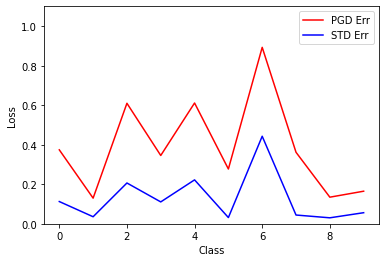

In [ ]:
print('Adversarially Trained Fashion MNIST Model')
show_both_losses_by_class(adv_model_pgd_loss, adv_model_regular_loss, acc=True)

FRL (RW) Equally Weighted Fashion MNIST Model


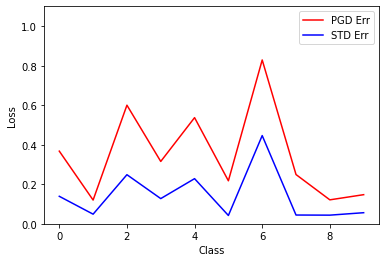

In [ ]:
print('FRL (RW) Equally Weighted Fashion MNIST Model')
show_both_losses_by_class(eq_fair_model_pgd_loss, eq_fair_model_regular_loss, acc=True)

FRL (RW) Natural Weighted Fashion MNIST Model


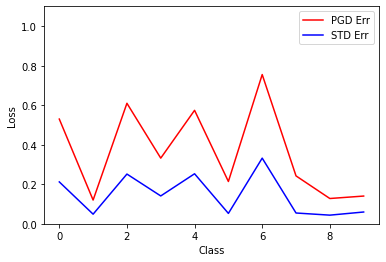

In [ ]:
print('FRL (RW) Natural Weighted Fashion MNIST Model')
show_both_losses_by_class(nat_fair_model_pgd_loss, nat_fair_model_regular_loss, acc=True)

FRL (RW) Boundary Weighted Fashion MNIST Model


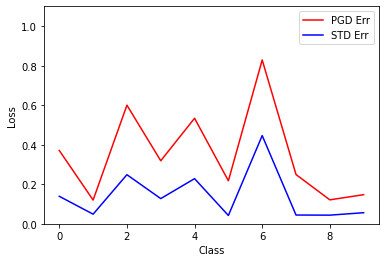

In [ ]:
print('FRL (RW) Boundary Weighted Fashion MNIST Model')
show_both_losses_by_class(bnd_fair_model_pgd_loss, bnd_fair_model_regular_loss, acc=True)

#### Conclusion

As with the authors of the paper, we find that the alpha ratio that favors the natural error is successfull in decreating the unfairness of the standard error in the model, and does help somewhat with the unfairness of the PGD error. 

